In [1]:
# Import the packages for experiment
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf

import time
import random
import pickle
import keras

from keras import layers
from itertools import product
from math import log2, ceil 
from joblib import Parallel, delayed
from multiprocessing import Pool
from sklearn.model_selection import StratifiedKFold, train_test_split

# Random Classification Experiment

This experiment will use images from the **CIFAR-100** database (https://www.cs.toronto.edu/~kriz/cifar.html) and showcase the classification efficiency of algorithms in the **Progressive Learning** project (https://github.com/neurodata/progressive-learning).

## Progressive Learning

The Progressive Learning project aims to improve program performance on sequentially learned tasks, proposing a lifelong learning approach. It contains two different algorithms: **Lifelong Learning Forests** (L2F) and **Lifelong Learning Network** (L2N). L2F uses Uncertainy Forest as transformers, while L2N uses deep networks. These two algorithms achieve both forward knowledge transfer and backward knowledge transfer, and this experiment is designed to cover both models.

In [2]:
# Import the progressive learning packages
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer 
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

### Separating data sets

The method will separate the data into training and testing subsets. The whole process is randomized to ensure the tests' validity.

In [3]:
# The method randomly selects training and testing subsets from the original datasets,
# making cross-validation on program results possible.
def cross_val_data(data_x, data_y, num_points_per_task, total_task=10, shift=1, slot=0, task=0):
    skf = StratifiedKFold(n_splits=6)
    for _ in range(shift + 1):
        train_idx, test_idx = next(skf.split(data_x, data_y))
        
    data_x_train, data_y_train = data_x[train_idx], data_y[train_idx]
    data_x_test, data_y_test = data_x[test_idx], data_y[test_idx]
    
    selected_classes = np.random.choice(range(0, 100), total_task)
    train_idxs_of_selected_class = np.array([np.where(data_y_train == y_val)[0] for y_val in selected_classes])
    num_points_per_class_per_slot = [int(len(train_idxs_of_selected_class[class_idx]) // total_task) 
                                     for class_idx in range(len(selected_classes))]
    selected_idxs = np.concatenate([np.random.choice(train_idxs_of_selected_class[class_idx], 
                                                     num_points_per_class_per_slot[class_idx]) 
                                    for class_idx in range(len(selected_classes))])
    train_idxs = np.random.choice(selected_idxs, num_points_per_task)
    data_x_train = data_x_train[train_idxs]
    data_y_train = data_y_train[train_idxs]
    
    test_idxs_of_selected_class = np.concatenate([np.where(data_y_test == y_val)[0] for y_val in selected_classes])
    data_x_test = data_x_test[test_idxs_of_selected_class]
    data_y_test = data_y_test[test_idxs_of_selected_class]
    
    return data_x_train, data_y_train, data_x_test, data_y_test

### Constructing experiments

This main method integrates both algorithms: L2F and L2N. When executing the experiment, users can choose between L2F and L2N models to generate desired results.

In [4]:
# The method runs the lifelong learning experiments
def L2_experiment(data_x, data_y, ntrees, shift, slot, model, num_points_per_task, acorn=None):
    
    # construct dataframes
    df = pd.DataFrame()
    shifts = []
    slots = []
    accuracies_across_tasks = []
    train_times_across_tasks = []
    inference_times_across_tasks = []
    
    # choose Uncertainty Forest as transformer
    if model == "uf":
        default_transformer_class = TreeClassificationTransformer
        default_transformer_kwargs = {"kwargs" : {"max_depth" : 30}}
        
        default_voter_class = TreeClassificationVoter
        default_voter_kwargs = {}
        
        default_decider_class = SimpleArgmaxAverage
    
    # choose deep neural network as transformer
    elif model == "dnn":
        default_transformer_class = NeuralClassificationTransformer
        
        network = keras.Sequential()
        network.add(layers.Conv2D(filters=16, kernel_size=(3, 3),
                                  activation='relu', input_shape=np.shape(train_x_task0)[1:]))
        network.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
                                  strides = 2, padding = "same", activation='relu'))
        network.add(layers.Conv2D(filters=64, kernel_size=(3, 3),
                                  strides = 2, padding = "same", activation='relu'))
        network.add(layers.Conv2D(filters=128, kernel_size=(3, 3),
                                  strides = 2, padding = "same", activation='relu'))
        network.add(layers.Conv2D(filters=254, kernel_size=(3, 3),
                                  strides = 2, padding = "same", activation='relu'))

        network.add(layers.Flatten())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.Dense(units=10, activation = 'softmax'))
        
        default_transformer_kwargs = {"network" : network, 
                                      "euclidean_layer_idx" : -2,
                                      "num_classes" : 10,
                                      "optimizer" : keras.optimizers.Adam(3e-4)}
        
        default_voter_class = KNNClassificationVoter
        default_voter_kwargs = {"k" : int(np.log2(num_points_per_task * .33))}
        
        default_decider_class = SimpleArgmaxAverage

    # construct the learner with model selected
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class)
    
    # randomly separate the training and testing subsets
    train_x_task0, train_y_task0, test_x_task0, test_y_task0 = cross_val_data(data_x, data_y,
                                                                              num_points_per_task,
                                                                              total_task=10,
                                                                              shift=shift, slot=slot)
    
    # training process
    train_start_time = time.time()
    progressive_learner.add_task(X = train_x_task0, y = train_y_task0,
                                 num_transformers = 1 if model == "dnn" else ntrees,
                                 transformer_voter_decider_split = [0.67, 0.33, 0],
                                 decider_kwargs = {"classes" : np.unique(train_y_task0)})
    train_end_time = time.time()
    
    # testing process
    inference_start_time = time.time()      
    task_0_predictions=progressive_learner.predict(test_x_task0, task_id = 0)
    inference_end_time = time.time()

    # record results
    shifts.append(shift)
    slots.append(slot)
    accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))
    train_times_across_tasks.append(train_end_time - train_start_time)
    inference_times_across_tasks.append(inference_end_time - inference_start_time)
        
    # repeating the tasks for 20 times
    for task_ii in range(1, 20):
        
        # randomly separate the training and testing subsets
        train_x, train_y, _, _ = cross_val_data(data_x, data_y, num_points_per_task,
                                                total_task=10, shift=shift, slot=slot, task = task_ii)
        
        # keeping track of experiment process in terminal
        print("Starting Task {} For Fold {} For Slot {}".format(task_ii, shift, slot))
        
        # training process
        train_start_time = time.time()
        progressive_learner.add_transformer(X = train_x, y = train_y,
                                            transformer_data_proportion = 1,
                                            num_transformers = 1 if model == "dnn" else ntrees,
                                            backward_task_ids = [0])
        train_end_time = time.time()
        
        # testing process
        inference_start_time = time.time()      
        task_0_predictions=progressive_learner.predict(test_x_task0, task_id = 0)
        inference_end_time = time.time()
        
        # record results
        shifts.append(shift)
        slots.append(slot)
        accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))
        train_times_across_tasks.append(train_end_time - train_start_time)
        inference_times_across_tasks.append(inference_end_time - inference_start_time)
        
        print("Accuracy Across Tasks: {}".format(accuracies_across_tasks))
        print("Train Times Across Tasks: {}".format(train_times_across_tasks))
        print("Inference Times Across Tasks: {}".format(inference_times_across_tasks))
        
    # finalize dataframes
    df['data_fold'] = shifts
    df['slot'] = slots
    df['accuracy'] = accuracies_across_tasks
    df['train_times'] = train_times_across_tasks
    df['inference_times'] = inference_times_across_tasks

    # save pickle file
    file_to_save = 'result/'+model+str(ntrees)+'_'+str(shift)+'_'+str(slot)+'.pickle'
    with open(file_to_save, 'wb') as f:
        pickle.dump(df, f)

### Processing parallel tasks
To ensure the experiment's efficiency, this method would make running parallel processes possible.

In [5]:
# The method allows multiple lifelong forest experiments to be run at the same time
def run_parallel_exp(data_x, data_y, n_trees, model, num_points_per_task, slot=0, shift=1):
    if model == "dnn":
        with tf.device('/gpu:'+str(shift % 4)):
            L2_experiment(data_x, data_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)
    else:
        L2_experiment(data_x, data_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)

### Choosing hyperparameters

The hyperparameters here, especially the `model`, are used for determining how the experiment will run. `uf` will use the L2F algorithm, while `dnn` will use the L2N algorithm.

In [6]:
### MAIN HYPERPARAMS ###
model = "uf" # choose "uf" or "dnn"
num_points_per_task = 500
slot_num = 10
shift_num = 6
alg_num = 1
task_num = 9
tree_num = 10
########################

### Loading data sets

The CITAR-100 database contains 100 classes of 600 images, each separating into 500 training images and 100 testing images. If the L2F model is chosen, the data will be fitted to the proper shape.

In [28]:
# load image data sets from the CIFAR-100 database
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

# modify data shapes for specific model
data_x = np.concatenate([X_train, X_test])
if model == "uf":
    data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

### Running experiment

Depending on the chosen model, the experiment will feed the data into proper parallel processes.

In [8]:
slot_fold = range(10)

# run the L2F model if selected
if model == "uf":
    shift_fold = range(1,7,1)
    n_trees = [10]
    iterable = product(n_trees,shift_fold, slot_fold)
    Parallel(n_jobs=-1,verbose=1)(
        delayed(run_parallel_exp)(
            data_x, data_y, ntree, model, num_points_per_task, slot=slot, shift=shift
        )
        for ntree,shift,slot in iterable
    )

# run the L2N model if selected
elif model == "dnn":
    print("Performing Stage 1 Shifts")
    for slot in slot_fold:
        
        def perform_shift(shift):
            return run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)
    
        stage_1_shifts = range(1, 5)
        with Pool(4) as p:
            p.map(perform_shift, stage_1_shifts)
            
    print("Performing Stage 2 Shifts")
    for slot in slot_fold:
        
        def perform_shift(shift):
            return run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)
    
        stage_2_shifts = range(5, 7)
        with Pool(4) as p:
            p.map(perform_shift, stage_2_shifts) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 71.0min finished


### Analyzing the results

After the experiment processes finish, the codes below will illustrate the training efficiency and time taken for both training and testing. Though individual computing time might vary, the whole process should be efficient enough to run on any common device.

In [9]:
# Import the packages for plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [10]:
# The method load information from pickle files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [11]:
reps = slot_num * shift_num

btes = []
train_times = []
inference_times = []

for slot in range(0, slot_num):
    for shift in range(shift_num):
        
        # load the pickle files
        filename = 'result/'+model+str(tree_num)+'_'+str(shift+1)+'_'+str(slot)+'.pickle'
        df = unpickle(filename)
        
        # calculate the backward transfer efficiency
        err = 1 - df['accuracy']
        bte = err[0] / err
        
        # record information
        btes.append(bte)
        train_times.append(df['train_times'])
        inference_times.append(df['inference_times'])

# calculate the average numbers
bte = np.mean(btes, axis = 0)
train_time_across_tasks = np.mean(train_times, axis = 0)
inference_time_across_tasks = np.mean(inference_times, axis = 0)

# setting plot parameters
fontsize=22
ticksize=20

### Plotting backward transfer efficiency

Backward transfer efficiency (BTE) measures the relative effect of future task data on the performance on a certain task. It is the expected ratio of two risk functions of the learned hypothesis, one with access to the data up to and including the last observation from task t, and the other with access to the entire data sequence.

\begin{align}
BTE^t(f_n):= E[R^t(f_n^{<t}) / R^t(f_n)] 
\end{align}



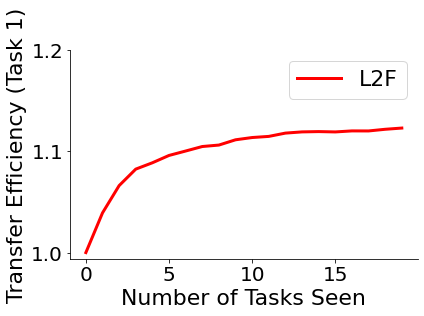

In [26]:
# plot the transfer efficiency
ax = plt.subplot(111)

# hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.plot(range(len(bte)), bte, c="blue" if model == "dnn" else "red", linewidth=3,
        linestyle="solid", label = "L2N" if model == "dnn" else "L2F")

ax.set_xlabel('Number of Tasks Seen', fontsize=fontsize)
ax.set_ylabel('Transfer Efficiency (Task 1)', fontsize=fontsize)
ax.set_yticks([1.0, 1.1, 1.2])
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=22)

In [22]:
# save the transfer efficiency figure
plt.tight_layout()
plt.savefig('./result/figs/random_class_'+model+'.pdf',dpi=300)
plt.close()

### Plotting time

The graph will show how training time and testing time change during the experiment.

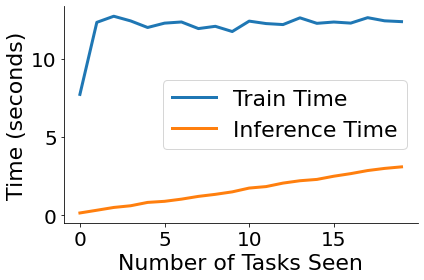

In [27]:
# plot the recorded times
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.plot(range(len(train_time_across_tasks)), train_time_across_tasks, linewidth=3,
        linestyle="solid", label = "Train Time")
ax.plot(range(len(inference_time_across_tasks)), inference_time_across_tasks, linewidth=3,
        linestyle="solid", label = "Inference Time")

ax.set_xlabel('Number of Tasks Seen', fontsize=fontsize)
ax.set_ylabel('Time (seconds)', fontsize=fontsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=22)

In [24]:
# save the time figure
plt.tight_layout()
plt.savefig('./result/figs/random_class_time_'+model+'.pdf',dpi=300)
plt.close()